## Create and test ion channel model

In [1]:
from experiments.ica_Li import (Li_iv_80,
                               Li_iv_60,
                                Li_iv_40,
                               Li_act,
                               Li_inact_1000,
                                Li_inact_300,
                                Li_inact_150,
                                Li_inact_kin_40,
                                Li_inact_kin_60,
                                Li_inact_kin_80,
                                Li_recov_80
                               )

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.4


In [2]:
modelfile = 'models/ical_simple.mmt'

In [3]:
observations, model, summary_statistics = setup(modelfile,
                                                Li_iv_80,
                                                   Li_act,
                                                Li_inact_300,
                                                Li_inact_kin_80,
                                                Li_recov_80
                                               )
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [25]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limitslog = {'i_caL.g_Ca_L' : (0,20),
          'i_caL.E_CaL' : (0,100),
          'log_i_caL.p_1': (-3,0),
          'log_i_caL.p_2': (-2,1),
          'log_i_caL.p_3': (-3,0),
          'log_i_caL.p_4': (-2,1),
          'log_i_caL.p_5': (-3,-1),
          'log_i_caL.p_6': (-2.5,-1),
          'log_i_caL.p_7': (-5,-2),
          'log_i_caL.p_8': (-2,0)}

limits = limitslog

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [9]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "simple_icaL_testing.db"))

In [10]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [11]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [13]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=0.885),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.4586351157115067, '1': 1.4586351157115067, '2': 1.4586351157115067, '3': 1.4586351157115067, '4': 1.4586351157115067, '5': 0.5361939848151068, '6': 0.3127314739074662, '7': 0.331160567148044, '8': 0.20849839273496834, '9': 0.23455767011100295, '10': 0.4502692866030265, '11': 1.4586351157115067, '12': 1.4586351157115067, '13': 1.4586351157115067, '14': 1.2763057262475686, '15': 1.2763057262475686, '16': 1.2763057262475686, '17': 1.2763057262475686, '18': 1.2763057262475686, '19': 1.2763057262475686, '20': 1.2763057262475686, '21': 1.0692267437828735, '22': 0.6526448955557794, '23': 0.5331952992869486, '24': 0.41965475538868524, '25': 0.43509659703718606, '26': 0.5346133718914368, '27': 1.2763057262475686, '28': 1.2763057262475686, '29': 1.2763057262475686, '30': 1.4586351157115067, '31': 1.3910898295521483, '32': 1.0240243387707855, '33': 0.6619222295902984, '34': 0.6538555934601938, '35': 0.9521793405520749, '36': 0.47214655970312996, '37': 0.7231

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc.load(db_path,8)

8

In [89]:
#abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=8, start_time=2019-08-28 17:30:23.068452, end_time=None)>


In [18]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0)

INFO:ABC:t:42 eps:0.8591279150593473
DEBUG:ABC:now submitting population 42
DEBUG:ABC:population 42 done
DEBUG:ABC:
total nr simulations up to t =42 is 6555733
DEBUG:Epsilon:new eps, t=43, eps=0.8506394499950782
INFO:ABC:t:43 eps:0.8506394499950782
DEBUG:ABC:now submitting population 43
DEBUG:ABC:population 43 done
DEBUG:ABC:
total nr simulations up to t =43 is 6679350
DEBUG:Epsilon:new eps, t=44, eps=0.8439772038503308
INFO:ABC:t:44 eps:0.8439772038503308
DEBUG:ABC:now submitting population 44
Process Process-199:
Process Process-200:
Process Process-186:
Process Process-197:
Process Process-161:
/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py:219: ResourceWarning: unclosed file <_io.TextIOWrapper name=137 mode='w+' encoding='UTF-8'>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
/home/brm18/.local/lib/python3.7/site-packages/ionchannelA

KeyboardInterrupt: 

  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/apps/anaconda/anaconda3-2019.07/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 560, in simulate_one
    transitions)
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/smc.py", line 560, in simulate_one
    transitions)
  File "/home/brm18/.local/l

  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 235, in summary_statistics
    for i, val in enumerate(sum_stats_combined(data))}
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 27, in <lambda>
    return lambda x: sum_stats_fn(x)
  File "/home/brm18/.local/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/experiment.py", line 25, in sum_stats_fn
    sum_stats = sum_stats+f(x[i])
  File "/home/brm18/New Ion channel/ion-channel-ABC/docs/examples/Nygren/experiments/ica_Li.py", line 517, in Li_inact_kin_80_sum_stats
    for d in data.split_periodic(tperiod_kin_80_Li, adjust = True):
  File "/home/brm18/.local/lib/python3.7/site-packages/myokit/_datalog.py", line 1124, in split_periodic
    while k < nlogs and t >= tstarts[k]:
KeyboardInterrupt
  File "/home/brm18/.local/lib/python3.7/site-packages/pyabc/transition/transitionm

# Results analysis

In [ ]:
#history.all_runs()

/apps/anaconda/anaconda3-2019.07/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


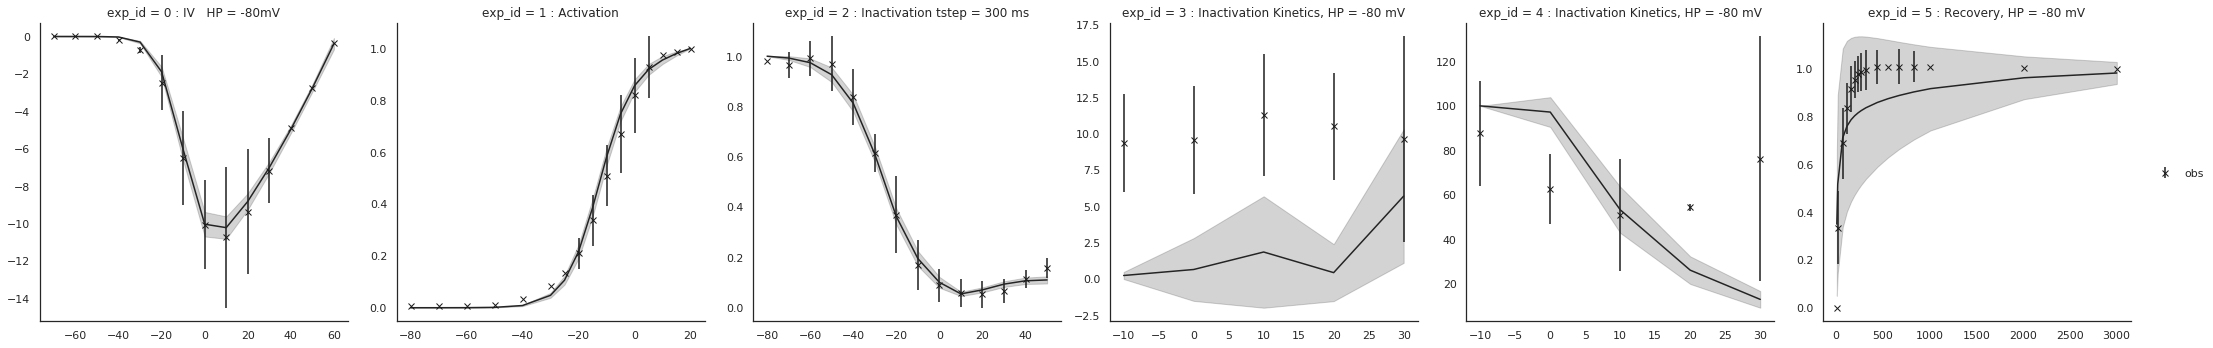

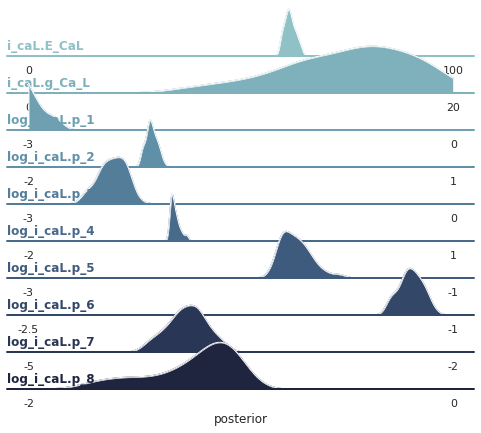

In [29]:
history = History(db_path)
history.id = 8

# Li experiments :

# IV corresponds to Li_iv_80 (HP = -80 mV)
# act corresponds to Li_act
# inact corresponds to Li_inact_300 (tstep = 300 ms)
# time constants corresponds to Li_inact_kin_80 (HP = -80 mV)
# recovery corresponds to Li_recov_80 (HP = -80 mV)
# all experiments corresponds to Li_iv_80, Li_act,Li_inact_300,Li_inact_kin_80,Li_recov_80


# history.id correspondance :

# 5 corresponds to the time constants (HP = -80mV) eps = 0.32  (24 iter)
# 6 corresponds to the recovery (HP = -80mV) eps = 0.14  (10 iter)
# 7 corresponds to the IV,Act,Inact eps = 0.19  (50 iter)
# 8 corresponds to all experiments eps = 0.885  (41 iter)
df, w = history.get_distribution(m=0)

grid1 = plot_sim_results(modelfile,Li_iv_80,Li_act,
                                                Li_inact_300,Li_inact_kin_80,Li_recov_80,                        
                         df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)
